# Differentially abundant taxa in incisors vs molars

## 1. Install and load required libraries 

In [1]:
# install.packages("remotes")
# remotes::install_github("bryandmartin/CORNCOB")

In [2]:
library(phyloseq, verbose=FALSE)
library(corncob, verbose=FALSE)
library(magrittr, verbose=FALSE)
library(ggplot2, verbose=FALSE)

Warning message:
“package ‘magrittr’ was built under R version 4.1.3”


## 2. Load phyloseq object

In [3]:
load("../02-diversity/master_phyloseq.RData")
ps.dat
# head(sample_data(ps.dat))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

## 3. Collapse data to species level

In [4]:
# head(tax_table(ps.dat))
ps.dat.glom <- ps.dat %>%
                phyloseq::subset_samples(tooth_type != "unknown" & tooth_type != "premolar") %>%
                tax_glom("V8")
ps.dat.glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 628 taxa and 1144 samples ]
sample_data() Sample Data:       [ 1144 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 628 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 628 tips and 627 internal nodes ]

## 4. Differential abundance test

### 4.1 First test using the full dataset

In [5]:
# differential abundance analysis
set.seed(234)
da_analysis <- differentialTest(formula = ~ tooth_type,
                               phi.formula = ~ tooth_type,
                               formula_null = ~ 1,
                               phi.formula_null = ~ tooth_type,
                               test = "Wald",
                               boot = FALSE,
                               data = ps.dat.glom,
                               fdr_cutoff = 0.01)
da_analysis

Object of class differentialTest 

$p: p-values 
$p_fdr: FDR-adjusted p-values 
$significant_taxa: taxa names of the statistically significant taxa 
$significant_models: model summaries of the statistically significant taxa 
$all_models: all model summaries 
$restrictions_DA: covariates tested for differential abundance 
$restrictions_DV: covariates tested for differential variability 
$discriminant_taxa_DA: taxa for which at least one covariate associated with the abundance was perfectly discriminant 
$discriminant_taxa_DV: taxa for which at least one covariate associated with the dispersion was perfectly discriminant 

plot( ) to see a plot of tested coefficients from significant taxa 

In [6]:
# plot results (modified from plot.differentialTest function in corncob)
# modified from plot_differentialTest.R in corncob
library(ggplot2)

level <- c("V8")
x <- da_analysis

signif_taxa <- otu_to_taxonomy(x$significant_taxa, x$data, level = level)
signif_taxa <- gsub("_", " ", signif_taxa) # NOTE: ASV label no longer informative after glom
signif_taxa
var_per_mod <- length(x$restrictions_DA) + length(x$restrictions_DV)
total_var_count <- length(signif_taxa) * var_per_mod
# initialize empty dataframe
df <- as.data.frame(matrix(NA, nrow = total_var_count, ncol = 5))
colnames(df) <- c("x", "xmin", "xmax", "taxa", "variable")

qval <- stats::qnorm(.975)
restricts_mu <- attr(x$restrictions_DA, "index")
restricts_phi <- attr(x$restrictions_DV, "index")

# loop through models to populate dataframe
count <- 1
for (i in 1:length(x$significant_models)) {
  # Below from print_summary_bbdml, just to get coefficient names
  tmp <- x$significant_models[[i]]
  coefs.mu <- tmp$coefficients[1:tmp$np.mu,, drop = FALSE]
  rownames(coefs.mu) <- paste0(substring(rownames(coefs.mu), 4), " Differential Abundance")
  coefs.mu <- coefs.mu[restricts_mu,, drop = FALSE]

  coefs.phi <- tmp$coefficients[(tmp$np.mu + 1):nrow(tmp$coefficients),, drop = FALSE]
  rownames(coefs.phi) <- paste0(substring(rownames(coefs.phi), 5), " Differential Variability")
  coefs.phi <- coefs.phi[restricts_phi - tmp$np.mu,, drop = FALSE]

  coefs <- rbind(coefs.mu, coefs.phi)
  for (j in 1:var_per_mod) {
    df[count, 1:3] <- c(coefs[j, 1], coefs[j, 1] - qval * coefs[j, 2],
                      coefs[j, 1] + qval * coefs[j, 2])
    df[count, 4:5] <- c(signif_taxa[i], rownames(coefs)[j])
    count <- count + 1
    }
}

head(df)

ASV348 
         "Chryseobacterium arthrosphaerae" 
                                     ASV75 
             "unclassified Capnocytophaga" 
                                     ASV86 
       "Capnocytophaga sp. oral taxon 903" 
                                     ASV37 
                "Capnocytophaga sputigena" 
                                    ASV727 
       "Capnocytophaga sp. oral taxon 863" 
                                    ASV562 
                "Capnocytophaga granulosa" 
                                   ASV1852 
                   "Abiotrophia defectiva" 
                                   ASV3651 
                    "Streptococcus oralis" 
                                   ASV1336 
                  "Streptococcus sp. 1643" 
                                     ASV54 
                 "Streptococcus sanguinis" 
                                     ASV11 
                    "Streptococcus mutans" 
                                    ASV133 
                 "Granulicatella adiacens" 
                                     ASV22 
                "Gemella haemolysans M341" 
                                     ASV72 
                 "Fusobacterium hwasookii" 
                                    ASV365 
         "Leptotrichia sp. oral taxon 212" 
                                     ASV15 
         "Leptotrichia sp. oral taxon 498" 
                                    ASV114 
                   "Leptotrichia buccalis" 
                                     ASV61 
         "Leptotrichia sp. oral taxon 417" 
                                     ASV14 
                      "Leptotrichia wadei" 
                                   ASV1214 
                     "Lautropia mirabilis" 
                                    ASV578 
        "Actinobaculum sp. oral taxon 183" 
                                   ASV3578 
                   "Schaalia odontolytica" 
                                   ASV1161 
                "Corynebacterium mustelae" 
                                    ASV663 
                   "Corynebacterium durum" 
                                      ASV5 
                     "Rothia dentocariosa" 
                                    ASV287 
                            "Rothia aeria" 
                                    ASV803 
            "Olsenella sp. oral taxon 807" 
                                      ASV9 
                      "Oribacterium sinus" 
                                    ASV569 
         "Oribacterium sp. oral taxon 078" 
                                    ASV924 
                          "Proteobacteria" 
                                   ASV1992 
                   "Selenomonas sp. F0473" 
                                   ASV1109 
                   "Centipeda periodontii" 
                                   ASV1158 
                       "Selenomonas noxia" 
                                   ASV1919 
                    "Selenomonas flueggei" 
                                   ASV4578 
                        "Blautia hansenii" 
                                     ASV60 
           "Lachnoanaerobaculum saburreum" 
                                    ASV740 
           "Lachnoanaerobaculum sp. MSX33" 
                                    ASV182 
            "Lachnoanaerobaculum umeaense" 
                                      ASV1 
"Lachnospiraceae bacterium oral taxon 096" 
                                    ASV942 
                    "Treponema socranskii" 
                                    ASV150 
                  "Campylobacter gracilis" 
                                     ASV53 
                        "Neisseria mucosa" 
                                    ASV104 
                         "Neisseria sicca" 
                                   ASV1885 
                     "Neisseria lactamica" 
                                    ASV627 
                      "Neisseria elongata" 
                                   ASV1225 
                  "Kingella deni

,x,xmin,xmax,taxa,variable
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.61049026,-0.16988777,1.3908683,Chryseobacterium arthrosphaerae,tooth_typeincisor Differential Abundance
2,-0.15830726,-0.89548363,0.5788691,Chryseobacterium arthrosphaerae,tooth_typemolar Differential Abundance
3,-0.09296863,-1.80352658,1.6175893,unclassified Capnocytophaga,tooth_typeincisor Differential Abundance
4,1.01005117,-0.60450602,2.6246084,unclassified Capnocytophaga,tooth_typemolar Differential Abundance
5,1.79804101,-0.03901399,3.6350960,Capnocytophaga sp. oral taxon 903,tooth_typeincisor Differential Abundance
6,2.68138692,0.94616708,4.4166068,Capnocytophaga sp. oral taxon 903,tooth_typemolar Differential Abundance


png 
  2

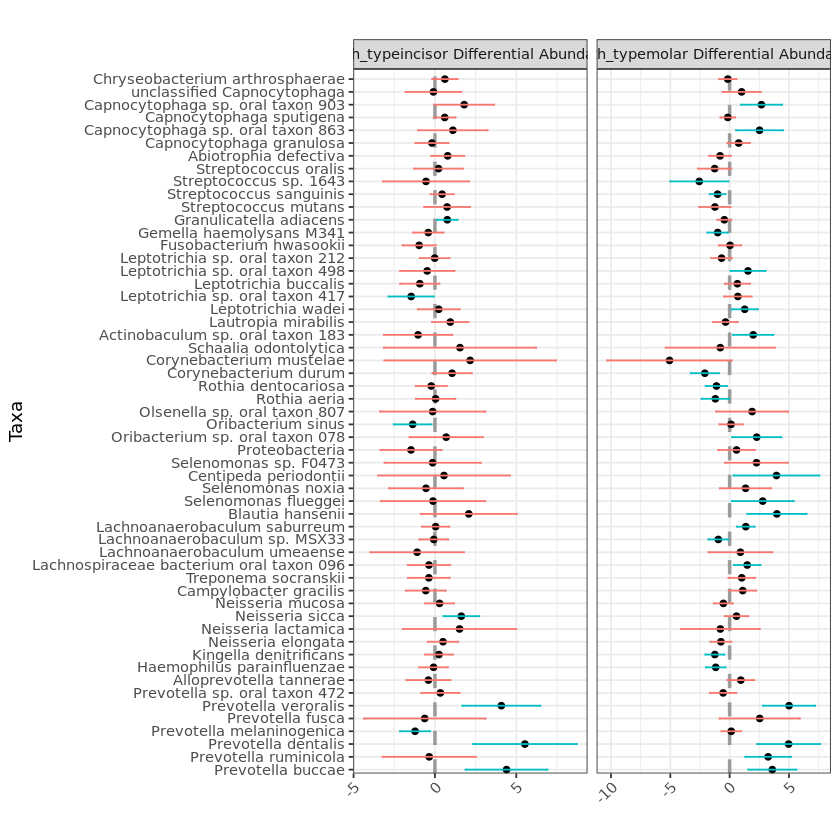

In [7]:
pdf("test.pdf")
ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend
dev.off()

ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend

## Balance of taxa molar vs incisor

### Balance of taxa among all groups

In [8]:
# also do a balance analysis -- which groups of taxa are predictive of molar vs incisor status?
# remove any taxa with fewer than 10 counts and in at least 5% of samples post merging 
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
# only include taxa that are healthly and are either molar or incisor
glom <- subset_samples(glom, aliquot_type == "H-CF" & tooth_type != "canine")                    
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 269 taxa and 779 samples ]
sample_data() Sample Data:       [ 779 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 269 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 269 tips and 268 internal nodes ]

In [9]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [10]:
library(dplyr)
library(tidyverse)
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
Warning message:
“package ‘lubridate’ was built under R version 4.1.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ─────────────────

In [11]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)

[1] 779 268

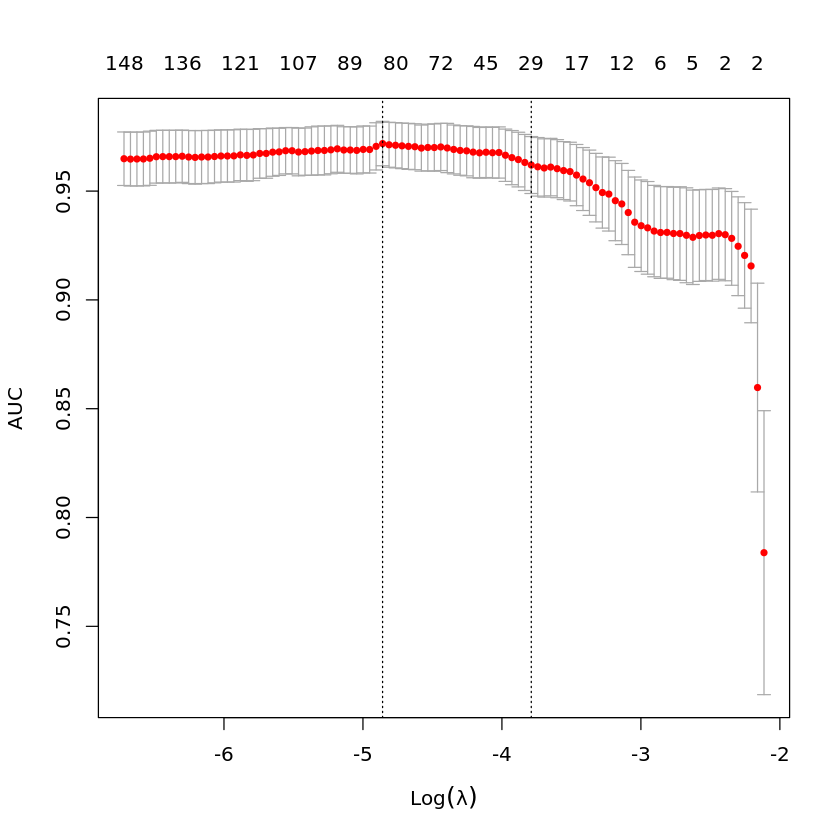

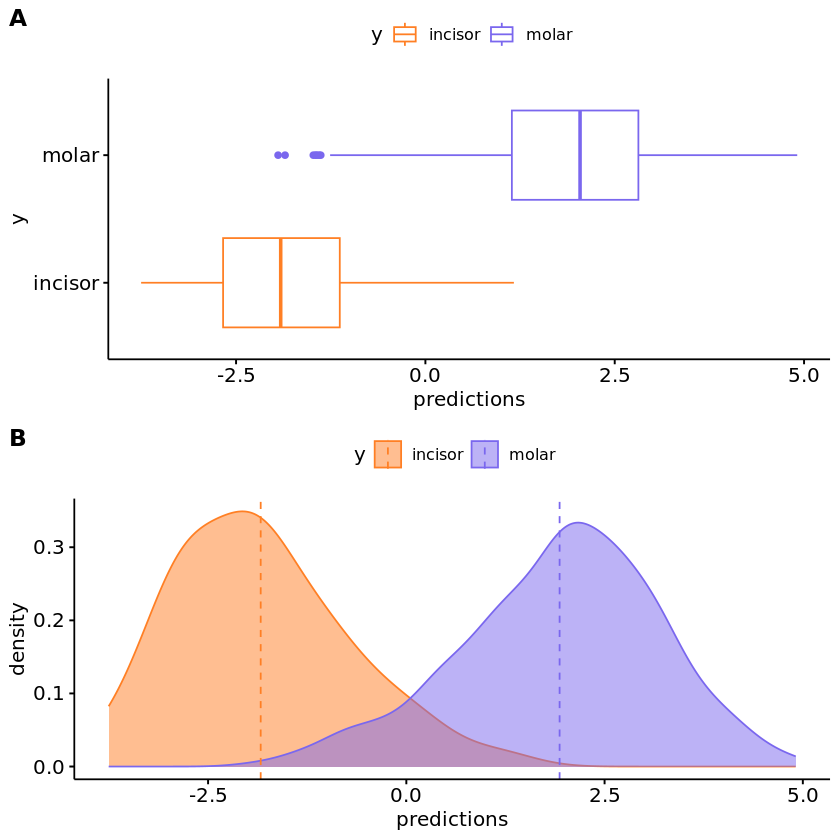

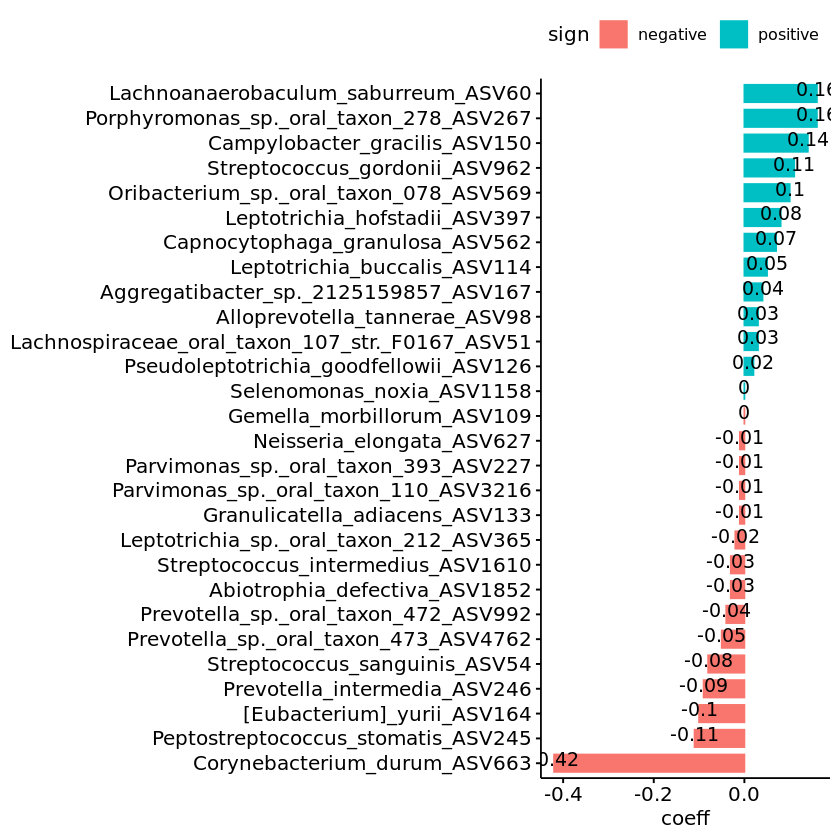

In [12]:
# install.packages("coda4microbiome")
library(coda4microbiome)
set.seed(852)
bal <- coda_glmnet(x, y)

In [13]:
pdf("balance_incisor_v_molar.pdf")
bal$`predictions plot`
bal$`signature plot`
dev.off()

png 
  2

### HUU 

In [21]:
# by HIV status group
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
glom <- subset_samples(glom, hiv_status == "HUU" & tooth_type != "canine")                    
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 269 taxa and 349 samples ]
sample_data() Sample Data:       [ 349 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 269 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 269 tips and 268 internal nodes ]

In [22]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [23]:
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

In [24]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)

[1] 349 268

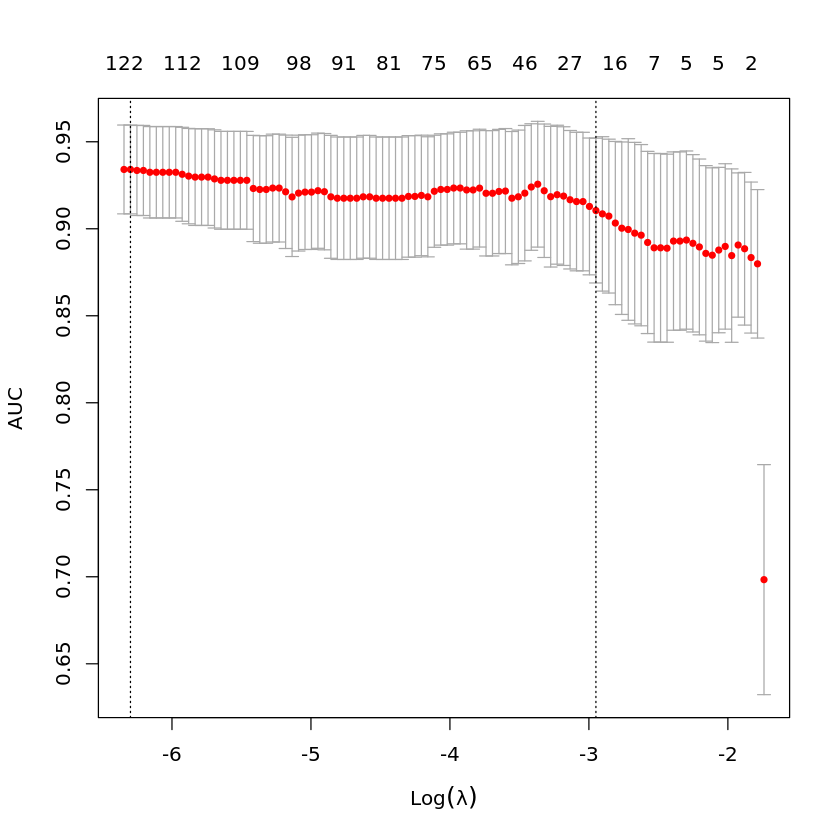

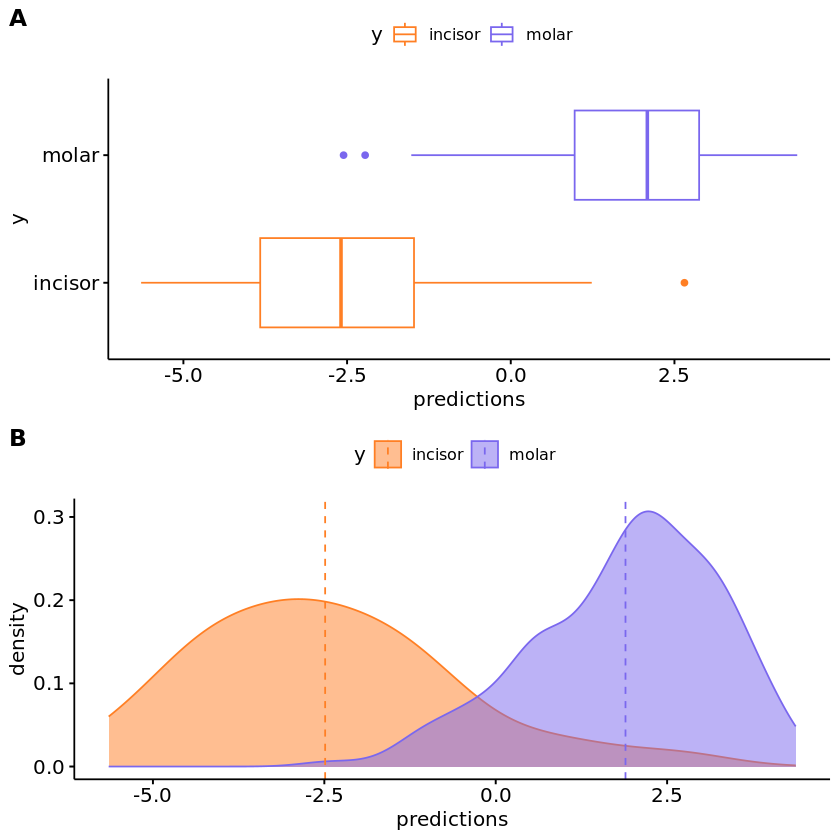

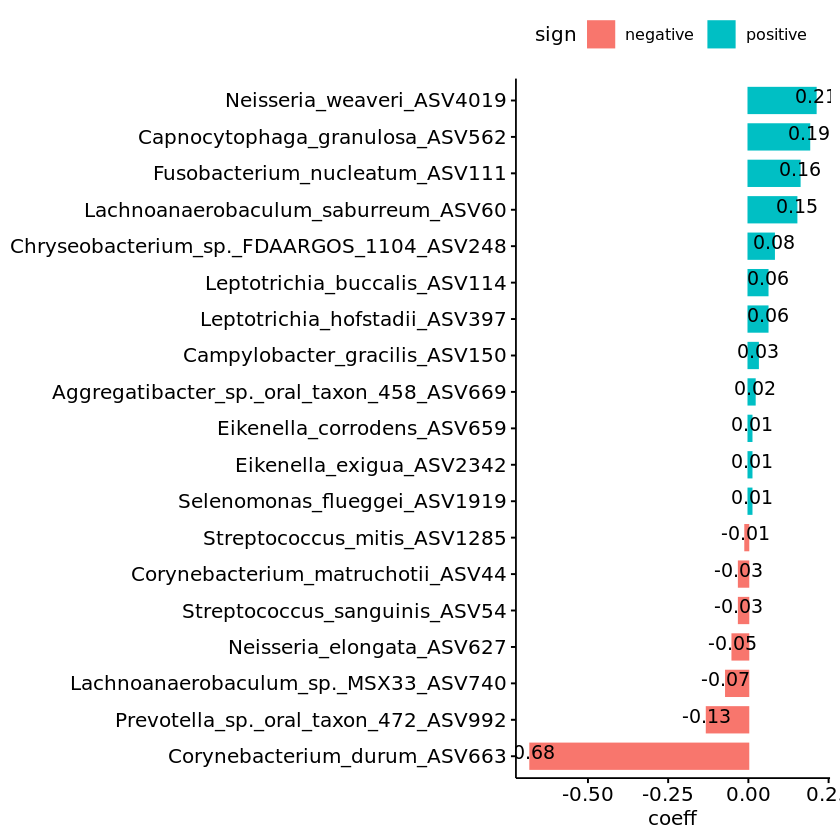

In [25]:
set.seed(852)
bal <- coda_glmnet(x, y)

### HI

In [ ]:
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
glom <- subset_samples(glom, hiv_status == "HI" & tooth_type != "canine")                    
glom

In [ ]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [ ]:
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

In [ ]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)

In [ ]:
set.seed(852)
bal <- coda_glmnet(x, y)

### HEU

In [ ]:
# by HIV status group
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
glom <- subset_samples(glom, hiv_status == "HEU")                    
glom
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)
set.seed(852)
bal <- coda_glmnet(x, y)